# Нейронные сети и PyTorch

In [36]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import MeanSquaredError, MulticlassAccuracy, MulticlassAUROC, MulticlassPrecision, MulticlassRecall
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

## Обзор Torch

### Пример линейной регрессии

In [37]:
n = 500
k = 3

x = torch.randn(n, k)
w_true = torch.Tensor((2., 3., -1.))
b_true = torch.Tensor([5])
y = torch.matmul(x, w_true) + b_true + 0.1 * torch.randn(n)
y

tensor([ 5.7908e+00,  7.3825e+00,  1.1816e+01,  6.3586e+00,  2.9687e+00,
         1.6900e+00,  4.4590e+00,  6.7741e+00,  5.6414e+00,  3.4991e+00,
         2.2739e+00,  5.4418e+00,  9.1833e-01,  1.8714e+00,  1.1090e+01,
         6.2988e+00,  8.6956e+00,  4.0661e+00,  1.2429e+01,  7.8891e+00,
         2.6451e+00, -2.9147e+00,  3.7093e+00,  5.2233e+00, -2.7751e+00,
         7.0126e+00,  8.9861e+00,  9.1426e+00,  1.0538e+01,  1.9330e+00,
        -3.4616e+00,  4.3736e+00,  1.0955e+01,  6.7037e+00,  3.8898e+00,
         8.9260e+00,  7.4411e+00,  1.1924e+01,  8.8904e+00,  3.4235e+00,
         5.3600e+00,  5.7218e+00,  3.4322e+00,  1.1864e+00,  3.5398e+00,
         1.4901e+00,  5.8310e+00,  7.1913e+00,  7.6345e+00,  1.9844e+00,
        -4.5601e+00,  3.3812e+00,  5.9268e+00,  1.6543e+00,  1.9202e+00,
         8.9296e+00,  4.5833e+00,  6.0962e+00,  5.2556e+00,  6.5372e+00,
         3.1004e+00,  3.9151e+00,  7.8078e+00,  3.7842e+00,  9.3827e+00,
         6.5339e+00,  2.8896e+00,  2.2334e+00,  7.6

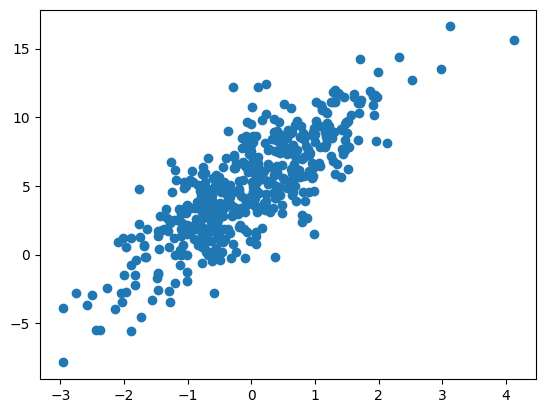

In [38]:
plt.scatter(x.numpy()[:, 1], y.numpy())

### Градиетнтый спуск, написанный на Torch

In [39]:
epoch = 100
alpha = 0.001
w = torch.randn(k, requires_grad=True)
b = torch.randn(1, requires_grad=True)

for i in range(epoch):
    y_pred = torch.matmul(x, w) + b
    loss = torch.square(y_pred - y).sum()
    loss.backward()

    with torch.no_grad():
        w -= alpha * w.grad
        b -= alpha * b.grad

        w.grad = None
        b.grad = None

print(w, b)

tensor([ 2.0008,  2.9975, -0.9999], requires_grad=True) tensor([4.9976], requires_grad=True)


### Нелинейная регрессия на модельных данных

Генерируем синтетических данных: $y = sin(x) + \xi$

In [40]:
np.random.seed(42)
x = np.linspace(-2 * np.pi, 2 * np.pi, 500)
np.random.shuffle(x)
y = np.sin(x) + 0.1 * np.random.randn(*x.shape)

Предобрабатываем данные:

In [41]:
# Создание pandas DataFrame
df = pd.DataFrame({'x': x, 'y': y})

# Преобразуем в тензоры
X = torch.tensor(df['x'].values, dtype=torch.float32).view(-1, 1)
Y = torch.tensor(df['y'].values, dtype=torch.float32).view(-1, 1)

# Разделение на обучающую и тестовую выборки
train_size = int(0.8 * len(df))
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

Определим простую нейронную сеть:

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            # Линейный слой 
            nn.Linear(1, 64),
            # Нелинейность
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

Инициализируем модель, функцию потерь и оптимизатор:

In [43]:
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Цикл обучения:

In [44]:
epochs = 1000

# Перекючаем модель в режим обучения
model.train()

for epoch in range(epochs):
    # Обнуляем градиенты, чтобы стереть старые значения
    optimizer.zero_grad()
    # Получаем предсказания на трейне
    outputs = model(X_train)
    # На них вычисляем функцию потерь
    loss = criterion(outputs, Y_train)
    # Делаем backward
    loss.backward()
    # Делаем шаг оптимизации
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f"Эпоха {epoch+1}/{epochs}, Потери: {loss.item():.4f}")

Эпоха 100/1000, Потери: 0.0640
Эпоха 200/1000, Потери: 0.0157
Эпоха 300/1000, Потери: 0.0125
Эпоха 400/1000, Потери: 0.0133
Эпоха 500/1000, Потери: 0.0112
Эпоха 600/1000, Потери: 0.0115
Эпоха 700/1000, Потери: 0.0111
Эпоха 800/1000, Потери: 0.0110
Эпоха 900/1000, Потери: 0.0109
Эпоха 1000/1000, Потери: 0.0108


Ошибка на тестовых данных:

In [45]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)

metric = MeanSquaredError()
metric.update(predictions, Y_test)
metric.compute()

tensor(0.0142)

Визуализируем результаты:

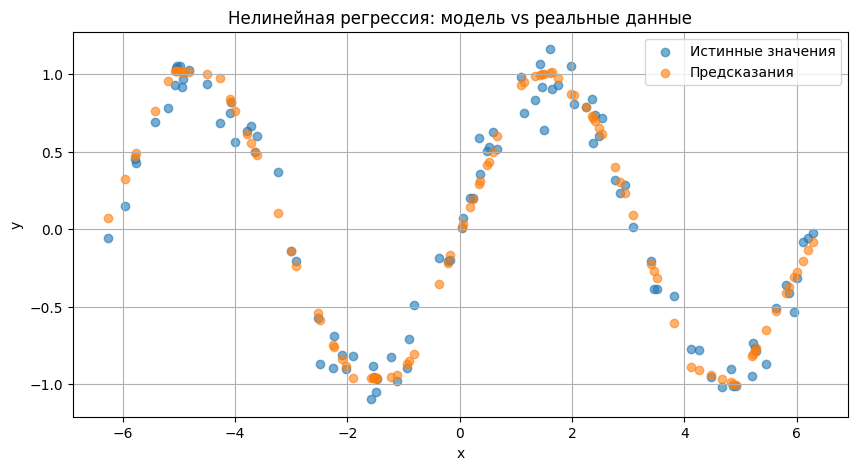

In [46]:
# Визуализация результата
plt.figure(figsize=(10, 5))
plt.scatter(X_test.numpy(), Y_test.numpy(), label='Истинные значения', alpha=0.6)
plt.scatter(X_test.numpy(), predictions.numpy(), label='Предсказания', alpha=0.6)
plt.legend()
plt.title("Нелинейная регрессия: модель vs реальные данные")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## Цикл обучения в Torch

In [47]:
df = pd.read_csv('data/Iris.csv').sample(frac=1, random_state=42, ignore_index=True)
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,74,6.1,2.8,4.7,1.2,Iris-versicolor
1,19,5.7,3.8,1.7,0.3,Iris-setosa
2,119,7.7,2.6,6.9,2.3,Iris-virginica
3,79,6.0,2.9,4.5,1.5,Iris-versicolor
4,77,6.8,2.8,4.8,1.4,Iris-versicolor


Размеры датасета:

In [48]:
print(df.shape)

(150, 6)


Распределение классов:

In [49]:
df['Species'].value_counts()

Species
Iris-versicolor    50
Iris-setosa        50
Iris-virginica     50
Name: count, dtype: int64

Получим матрицу признаков `X` и вектор ответов `y`. При обучении мы можем оперировать только с числами, поэтому закодируем каждый класс числом (0, 1, 2).

In [50]:
def preprocess(df):
    X = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']].values.astype(np.float32)
    y = df['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}).values
    return X, y

In [51]:
X, y = preprocess(df)
X_train, y_train = X[:100], y[:100]
X_valid, y_valid = X[100:125], y[100:125]
X_test, y_test = X[125:150], y[125:150]

### Свой загрузчик данных 

In [52]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return self.X.shape[0]

In [53]:
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

Посмотрим, что можно делать с датасетами. Мы можем получить его размер с помощью len(...). Для этого мы реализовали метод `__len__`:

In [54]:
print(len(train_dataset))

100


Мы также можем обращаться к массиву, используя различные виды индексирования:

In [55]:
x, y = train_dataset[0]
print(x, y)

[6.1 2.8 4.7 1.2] 1


In [56]:
X_batch, y_batch = train_dataset[:5]
print(X_batch)
print(y_batch)

[[6.1 2.8 4.7 1.2]
 [5.7 3.8 1.7 0.3]
 [7.7 2.6 6.9 2.3]
 [6.  2.9 4.5 1.5]
 [6.8 2.8 4.8 1.4]]
[1 0 2 1 1]


In [57]:
X_batch, y_batch = train_dataset[[0, 2, 5]]
print(X_batch)
print(y_batch)

[[6.1 2.8 4.7 1.2]
 [7.7 2.6 6.9 2.3]
 [5.4 3.4 1.5 0.4]]
[1 2 0]


Класс `DataLoader` нужен для автоматического формирования батчей для заданного датасета. 

In [58]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, drop_last=True)

In [59]:
batches = [x for x in train_loader]
print(len(batches))
print(batches[0])
print(batches[1])

12
[tensor([[5.4000, 3.4000, 1.5000, 0.4000],
        [7.7000, 3.8000, 6.7000, 2.2000],
        [5.6000, 2.7000, 4.2000, 1.3000],
        [6.3000, 2.8000, 5.1000, 1.5000],
        [5.6000, 2.9000, 3.6000, 1.3000],
        [4.4000, 3.2000, 1.3000, 0.2000],
        [5.0000, 3.5000, 1.3000, 0.3000],
        [4.9000, 3.1000, 1.5000, 0.1000]]), tensor([0, 2, 1, 2, 1, 0, 0, 0])]
[tensor([[5.7000, 3.8000, 1.7000, 0.3000],
        [4.8000, 3.4000, 1.9000, 0.2000],
        [4.9000, 3.1000, 1.5000, 0.1000],
        [6.5000, 3.2000, 5.1000, 2.0000],
        [5.0000, 2.3000, 3.3000, 1.0000],
        [5.1000, 3.4000, 1.5000, 0.2000],
        [4.7000, 3.2000, 1.6000, 0.2000],
        [5.7000, 4.4000, 1.5000, 0.4000]]), tensor([0, 0, 0, 2, 1, 0, 0, 0])]


### Пишем модель

In [60]:
class ClassificationModel(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, n_outputs),
            nn.Softmax(1)
        )

    def forward(self, x):
        output = self.model(x)
        return output

## Обучение модели

Сделаем эксперименты воспроизводимыми

In [61]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Зададим параметры обучения

In [62]:
# Количество эпох (полных проходов по датасету)
n_epochs = 128

# Размерность входа
n_inputs = 4

# Размерность выхода (кол-во классов)
n_outputs = 3

# Скорость обучения (learning rate)
lr = 1e-3

Инициализируем модель, функцию потерь и оптимизатор

In [63]:
model = ClassificationModel(n_inputs=n_inputs, n_outputs=n_outputs)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

Реализуем вычисление потерь на валидационном датасете

In [64]:
def compute_validation_loss(model, loader, loss_func):
    loss = 0
    # Используем нейросеть в режиме применения (отключаем Dropout, ...)
    model.eval()
    for x, y in loader:
        # Нам не нужно вычислять градиенты, поэтому можно сэкономить память
        with torch.no_grad():
            logits = model(x)
        loss += loss_func(logits, y).item() / len(loader)
    return loss

Реализуем цикл обучения нейросети (внешний цикл по эпохам, а внутренний -- по батчам). В конце каждой эпохи будем считать потери на валидационном датасете.

In [65]:
train_losses = []
eval_losses = []

for i in range(1, n_epochs + 1):
    print(f'Epoch {i}')
    for x, y in train_loader:
        # Переводим модель в режим обучения (включаем Dropout, ...)
        model.train()
        logits = model(x)

        loss = loss_func(logits, y)
        # Сбрасываем градиенты (.backward() только прибавляет новые градиенты к текущим)
        optimizer.zero_grad()
        # Вычисляем градиенты
        loss.backward()
        # Обновляем параметры нейросети
        optimizer.step()
    # Считаем и выводим потери на валидационном датасете
    eval_loss = compute_validation_loss(model, valid_loader, loss_func)
    train_losses.append(loss.item())
    eval_losses.append(eval_loss)
    print(f'train_loss={loss.item()}, eval_loss={eval_loss}')

Epoch 1
train_loss=1.0057919025421143, eval_loss=1.0776783227920532
Epoch 2
train_loss=1.1964929103851318, eval_loss=1.046557903289795
Epoch 3
train_loss=0.9436208009719849, eval_loss=0.9855746825536091
Epoch 4
train_loss=0.9637491703033447, eval_loss=0.9370900392532349
Epoch 5
train_loss=0.9181653261184692, eval_loss=0.9169047872225444
Epoch 6
train_loss=0.9185007214546204, eval_loss=0.8814437190691631
Epoch 7
train_loss=0.7306329011917114, eval_loss=0.8643720746040344
Epoch 8
train_loss=0.8113806247711182, eval_loss=0.8416738907496133
Epoch 9
train_loss=1.0095887184143066, eval_loss=0.8474067846933999
Epoch 10
train_loss=0.7144458293914795, eval_loss=0.8258770108222961
Epoch 11
train_loss=0.691935658454895, eval_loss=0.7876412669817607
Epoch 12
train_loss=0.7111085653305054, eval_loss=0.7897605498631797
Epoch 13
train_loss=0.8243023753166199, eval_loss=0.8035155534744262
Epoch 14
train_loss=0.7946643233299255, eval_loss=0.7678120136260986
Epoch 15
train_loss=0.8093571662902832, eval_

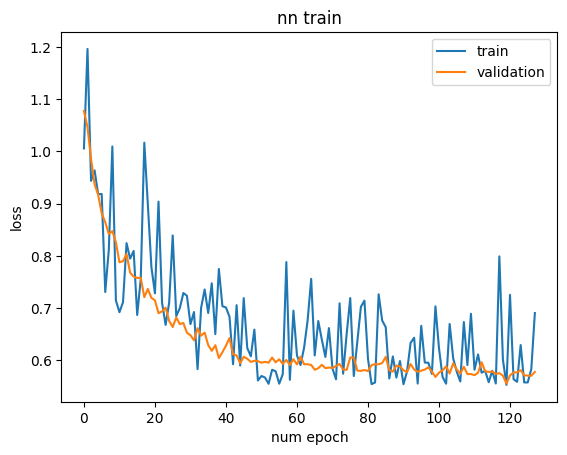

In [66]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(eval_losses)
plt.legend(["train", "validation"])
plt.xlabel("num epoch")
plt.ylabel("loss")
plt.title("nn train")
plt.show()

### Оценим модель по метрикам

In [67]:
model.eval()
with torch.no_grad():
    predictions = model(torch.tensor(X_test))

metric = MulticlassRecall()
metric.update(torch.argmax(predictions, dim=1), torch.tensor(y_test))
metric.compute()

tensor(1.)

In [68]:
metric = MulticlassAUROC(num_classes=3)
metric.update(predictions, torch.tensor(y_test))
metric.compute()

tensor(1.)

In [69]:
metric = MulticlassPrecision()
metric.update(predictions, torch.tensor(y_test))
metric.compute()

tensor(1.)

In [70]:
metric = MulticlassRecall()
metric.update(predictions, torch.tensor(y_test))
metric.compute()

tensor(1.)